Total Game Score Model - Model Evaluation - GBM

In [1]:
import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('..')
from total_points_model.config import raw_data_file_path
from total_points_model.domain.preprocessing.data_preprocessor import DataPreprocessor
from total_points_model.domain.contracts.mappings import Mappings
from total_points_model.domain.contracts.modelling_data_contract import ModellingDataContract
from total_points_model.domain.modelling.supermodel import SuperXGBRegressor
from total_points_model.domain.modelling.model_evaluation import XGBRegressorEvaluator

pd.options.display.max_rows = 100
pd.options.display.max_columns = 999

%load_ext autoreload
%autoreload 2

New Model

In [2]:
model_file_path = '/Users/ciaran/Documents/Projects/AFL/total-points-score-model/afl-total-points-model/total_points_model/models/xgb_total_points_v2.joblib'
preproc_file_path = '/Users/ciaran/Documents/Projects/AFL/total-points-score-model/afl-total-points-model/total_points_model/preprocessors/preprocessor_v2.joblib'

Comparison Model

In [3]:
compare_train_predictions_file_path = '/Users/ciaran/Documents/Projects/AFL/total-points-score-model/afl-total-points-model/total_points_model/predictions/train_predictions_xgb_regression_test_v1.csv'
compare_test_predictions_file_path = '/Users/ciaran/Documents/Projects/AFL/total-points-score-model/afl-total-points-model/total_points_model/predictions/test_predictions_xgb_regression_test_v1.csv'

Load Data

In [4]:
afl_data = pd.read_csv(raw_data_file_path)
afl_data = afl_data[afl_data['Year'] < 2023]

In [5]:
training_data = afl_data[afl_data['ModellingFilter']]
test_data = afl_data[~afl_data['ModellingFilter']]

In [6]:
response = ModellingDataContract.response

In [7]:
X_train, y_train = training_data.drop(columns = [response]), training_data[response]
X_test, y_test = test_data.drop(columns = [response]), test_data[response]

In [8]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2755, 27), (2755,), (783, 27), (783,))

Preprocess Data

In [9]:
preprocessor = joblib.load(preproc_file_path)

In [10]:
X_train_preproc = preprocessor.transform(X_train)
X_test_preproc = preprocessor.transform(X_test)

In [11]:
X_train_preproc.head()

,Round,Year,Temperature,random5,Home_Total_Q4_Score_avg2,Home_Total_Q4_Goals_avg2,Home_Total_Q4_Behinds_avg2,Home_Total_Q4_Shots_avg2,Home_Total_Q4_Conversion_avg2,Home_Att_Q4_Score_avg2,Home_Att_Q4_Goals_avg2,Home_Att_Q4_Behinds_avg2,Home_Att_Q4_Shots_avg2,Home_Att_Q4_Conversion_avg2,Home_Def_Q4_Score_avg2,Home_Def_Q4_Goals_avg2,Home_Def_Q4_Behinds_avg2,Home_Def_Q4_Shots_avg2,Home_Def_Q4_Conversion_avg2,Away_Total_Q4_Score_avg2,Away_Total_Q4_Goals_avg2,Away_Total_Q4_Behinds_avg2,Away_Total_Q4_Shots_avg2,Away_Total_Q4_Conversion_avg2,Away_Att_Q4_Score_avg2,Away_Att_Q4_Goals_avg2,Away_Att_Q4_Behinds_avg2,Away_Att_Q4_Shots_avg2,Away_Att_Q4_Conversion_avg2,Away_Def_Q4_Score_avg2,Away_Def_Q4_Goals_avg2,Away_Def_Q4_Behinds_avg2,Away_Def_Q4_Shots_avg2,Away_Def_Q4_Conversion_avg2,Home_Team_Adelaide,Home_Team_Brisbane Lions,Home_Team_Carlton,Home_Team_Collingwood,Home_Team_Essendon,Home_Team_Fremantle,Home_Team_Geelong,Home_Team_Gold Coast,Home_Team_Greater Western Sydney,Home_Team_Hawthorn,Home_Team_Melbourne,Home_Team_North Melbourne,Home_Team_Port Adelaide,Home_Team_Richmond,Home_Team_St Kilda,Home_Team_Sydney,Home_Team_West Coast,Home_Team_Western Bulldogs,Away_Team_Adelaide,Away_Team_Brisbane Lions,Away_Team_Carlton,Away_Team_Collingwood,Away_Team_Essendon,Away_Team_Fremantle,Away_Team_Geelong,Away_Team_Gold Coast,Away_Team_Greater Western Sydney,Away_Team_Hawthorn,Away_Team_Melbourne,Away_Team_North Melbourne,Away_Team_Port Adelaide,Away_Team_Richmond,Away_Team_St Kilda,Away_Team_Sydney,Away_Team_West Coast,Away_Team_Western Bulldogs,Venue_Adelaide Oval,Venue_Bellerive Oval,Venue_Blacktown,Venue_Carrara,Venue_Cazalys Stadium,Venue_Docklands,Venue_Eureka Stadium,Venue_Football Park,Venue_Gabba,Venue_Jiangwan Stadium,Venue_Kardinia Park,Venue_M.C.G.,Venue_Manuka Oval,Venue_Marrara Oval,Venue_Perth Stadium,Venue_Princes Park,Venue_S.C.G.,Venue_Stadium Australia,Venue_Subiaco,Venue_Sydney Showground,Venue_Traeger Park,Venue_Wellington,Venue_York Park,City_Adelaide,City_Alice Springs,City_Ballarat,City_Brisbane,City_Cairns,City_Canberra,City_Darwin,City_Geelong,City_Gold Coast,City_Hobart,City_Launceston,City_Melbourne,City_Perth,City_Shanghai,City_Sydney,City_Wellington,Weather_Type_Bad,Weather_Type_Good
0,1,2005.0,18.0,4,181.188342,26.305829,23.35337,49.659199,0.528876,91.5,13.281603,11.810383,25.091985,0.526871,89.688342,13.024226,11.542987,24.567213,0.528248,181.774299,26.394976,23.404441,49.799418,0.52913,90.031853,13.076629,11.572079,24.648708,0.528787,91.742446,13.318347,11.832363,25.15071,0.52722,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,2005.0,18.0,3,181.188342,26.305829,23.35337,49.659199,0.528876,91.5,13.281603,11.810383,25.091985,0.526871,89.688342,13.024226,11.542987,24.567213,0.528248,181.774299,26.394976,23.404441,49.799418,0.52913,90.031853,13.076629,11.572079,24.648708,0.528787,91.742446,13.318347,11.832363,25.15071,0.52722,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,1,2005.0,18.0,2,181.188342,26.305829,23.35337,49.659199,0.528876,91.5,13.281603,11.810383,25.091985,0.526871,89.688342,13.024226,11.542987,24.567213,0.528248,181.774299,26.394976,23.404441,49.799418,0.52913,90.031853,13.076629,11.572079,24.648708,0.528787,91.742446,13.318347,11.832363,25.15071,0.52722,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,1,2005.0,18.0,3,181.188342,26.305829,23.35337,49.659199,0.528876,91.5,13.281603,11.810383,25.091985,0.526871,89.688342,13.024226,11.542987,24.567213,0.528248,181.774299,26.394976,23.404441,49.799418,0.52913,90.031853,13.076629,11.572079,24.648708,0.528787,91.742446,13.318347,11.832363,25.15071,0.52722,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,

Load Model

In [12]:
xgb_model = joblib.load(model_file_path)

Get Predictions

In [13]:
train_preds = xgb_model.predict(X_train_preproc)
test_preds = xgb_model.predict(X_test_preproc)

Compare Model

In [14]:
compare_train_data = pd.read_csv(compare_train_predictions_file_path)
compare_test_data = pd.read_csv(compare_test_predictions_file_path)

In [15]:
compare_train_data.head()

,Year,Temperature,random5,Home_Total_Q1_Score_avg2,Home_Total_Q1_Goals_avg2,Home_Total_Q1_Behinds_avg2,Home_Total_Q1_Shots_avg2,Home_Total_Q1_Conversion_avg2,Home_Total_Q2_Score_avg2,Home_Total_Q2_Goals_avg2,Home_Total_Q2_Behinds_avg2,Home_Total_Q2_Shots_avg2,Home_Total_Q2_Conversion_avg2,Home_Total_Q3_Score_avg2,Home_Total_Q3_Goals_avg2,Home_Total_Q3_Behinds_avg2,Home_Total_Q3_Shots_avg2,Home_Total_Q3_Conversion_avg2,Home_Total_Q4_Score_avg2,Home_Total_Q4_Goals_avg2,Home_Total_Q4_Behinds_avg2,Home_Total_Q4_Shots_avg2,Home_Total_Q4_Conversion_avg2,Home_Att_Q1_Score_avg2,Home_Att_Q1_Goals_avg2,Home_Att_Q1_Behinds_avg2,Home_Att_Q1_Shots_avg2,Home_Att_Q1_Conversion_avg2,Home_Att_Q2_Score_avg2,Home_Att_Q2_Goals_avg2,Home_Att_Q2_Behinds_avg2,Home_Att_Q2_Shots_avg2,Home_Att_Q2_Conversion_avg2,Home_Att_Q3_Score_avg2,Home_Att_Q3_Goals_avg2,Home_Att_Q3_Behinds_avg2,Home_Att_Q3_Shots_avg2,Home_Att_Q3_Conversion_avg2,Home_Att_Q4_Score_avg2,Home_Att_Q4_Goals_avg2,Home_Att_Q4_Behinds_avg2,Home_Att_Q4_Shots_avg2,Home_Att_Q4_Conversion_avg2,Home_Def_Q1_Score_avg2,Home_Def_Q1_Goals_avg2,Home_Def_Q1_Behinds_avg2,Home_Def_Q1_Shots_avg2,Home_Def_Q1_Conversion_avg2,Home_Def_Q2_Score_avg2,Home_Def_Q2_Goals_avg2,Home_Def_Q2_Behinds_avg2,Home_Def_Q2_Shots_avg2,Home_Def_Q2_Conversion_avg2,Home_Def_Q3_Score_avg2,Home_Def_Q3_Goals_avg2,Home_Def_Q3_Behinds_avg2,Home_Def_Q3_Shots_avg2,Home_Def_Q3_Conversion_avg2,Home_Def_Q4_Score_avg2,Home_Def_Q4_Goals_avg2,Home_Def_Q4_Behinds_avg2,Home_Def_Q4_Shots_avg2,Home_Def_Q4_Conversion_avg2,Away_Total_Q1_Score_avg2,Away_Total_Q1_Goals_avg2,Away_Total_Q1_Behinds_avg2,Away_Total_Q1_Shots_avg2,Away_Total_Q1_Conversion_avg2,Away_Total_Q2_Score_avg2,Away_Total_Q2_Goals_avg2,Away_Total_Q2_Behinds_avg2,Away_Total_Q2_Shots_avg2,Away_Total_Q2_Conversion_avg2,Away_Total_Q3_Score_avg2,Away_Total_Q3_Goals_avg2,Away_Total_Q3_Behinds_avg2,Away_Total_Q3_Shots_avg2,Away_Total_Q3_Conversion_avg2,Away_Total_Q4_Score_avg2,Away_Total_Q4_Goals_avg2,Away_Total_Q4_Behinds_avg2,Away_Total_Q4_Shots_avg2,Away_Total_Q4_Conversion_avg2,Away_Att_Q1_Score_avg2,Away_Att_Q1_Goals_avg2,Away_Att_Q1_Behinds_avg2,Away_Att_Q1_Shots_avg2,Away_Att_Q1_Conversion_avg2,Away_Att_Q2_Score_avg2,Away_Att_Q2_Goals_avg2,Away_Att_Q2_Behinds_avg2,Away_Att_Q2_Shots_avg2,Away_Att_Q2_Conversion_avg2,Away_Att_Q3_Score_avg2,Away_Att_Q3_Goals_avg2,Away_Att_Q3_Behinds_avg2,Away_Att_Q3_Shots_avg2,Away_Att_Q3_Conversion_avg2,Away_Att_Q4_Score_avg2,Away_Att_Q4_Goals_avg2,Away_Att_Q4_Behinds_avg2,Away_Att_Q4_Shots_avg2,Away_Att_Q4_Conversion_avg2,Away_Def_Q1_Score_avg2,Away_Def_Q1_Goals_avg2,Away_Def_Q1_Behinds_avg2,Away_Def_Q1_Shots_avg2,Away_Def_Q1_Conversion_avg2,Away_Def_Q2_Score_avg2,Away_Def_Q2_Goals_avg2,Away_Def_Q2_Behinds_avg2,Away_Def_Q2_Shots_avg2,Away_Def_Q2_Conversion_avg2,Away_Def_Q3_Score_avg2,Away_Def_Q3_Goals_avg2,Away_Def_Q3_Behinds_avg2,Away_Def_Q3_Shots_avg2,Away_Def_Q3_Conversion_avg2,Away_Def_Q4_Score_avg2,Away_Def_Q4_Goals_avg2,Away_Def_Q4_Behinds_avg2,Away_Def_Q4_Shots_avg2,Away_Def_Q4_Conversion_avg2,Home_Team_Adelaide,Home_Team_Brisbane Lions,Home_Team_Carlton,Home_Team_Collingwood,Home_Team_Essendon,Home_Team_Fremantle,Home_Team_Geelong,Home_Team_Gold Coast,Home_Team_Greater Western Sydney,Home_Team_Hawthorn,Home_Team_Melbourne,Home_Team_North Melbourne,Home_Team_Port Adelaide,Home_Team_Richmond,Home_Team_St Kilda,Home_Team_Sydney,Home_Team_West Coast,Home_Team_Western Bulldogs,Away_Team_Adelaide,Away_Team_Brisbane Lions,Away_Team_Carlton,Away_Team_Collingwood,Away_Team_Essendon,Away_Team_Fremantle,Away_Team_Geelong,Away_Team_Gold Coast,Away_Team_Greater Western Sydney,Away_Team_Hawthorn,Away_Team_Melbourne,Away_Team_North Melbourne,Away_Team_Port Adelaide,Away_Team_Richmond,Away_Team_St Kilda,Away_Team_Sydney,Away_Team_West Coast,Away_Team_Western Bulldogs,Venue_Adelaide Oval,Venue_Bellerive Oval,Venue_Carrara,Venue_Cazalys Stadium,Venue_Docklands,Venue_Eureka Stadium,Venue_Football Park,Venue_Gabba,Venue_Kardinia Park,Venue_M.C.G.,Venue_Manuka 

Evaluate Model

In [16]:
test_evaluation_data = X_test_preproc.copy()
test_evaluation_data['xgb_preds'] = xgb_model.predict(X_test_preproc)
test_evaluation_data['old_preds'] = compare_test_data['xgb_preds']
test_evaluation_data[response] = test_data[response].reset_index(drop=True)
test_evaluation_data.head()

,Round,Year,Temperature,random5,Home_Total_Q4_Score_avg2,Home_Total_Q4_Goals_avg2,Home_Total_Q4_Behinds_avg2,Home_Total_Q4_Shots_avg2,Home_Total_Q4_Conversion_avg2,Home_Att_Q4_Score_avg2,Home_Att_Q4_Goals_avg2,Home_Att_Q4_Behinds_avg2,Home_Att_Q4_Shots_avg2,Home_Att_Q4_Conversion_avg2,Home_Def_Q4_Score_avg2,Home_Def_Q4_Goals_avg2,Home_Def_Q4_Behinds_avg2,Home_Def_Q4_Shots_avg2,Home_Def_Q4_Conversion_avg2,Away_Total_Q4_Score_avg2,Away_Total_Q4_Goals_avg2,Away_Total_Q4_Behinds_avg2,Away_Total_Q4_Shots_avg2,Away_Total_Q4_Conversion_avg2,Away_Att_Q4_Score_avg2,Away_Att_Q4_Goals_avg2,Away_Att_Q4_Behinds_avg2,Away_Att_Q4_Shots_avg2,Away_Att_Q4_Conversion_avg2,Away_Def_Q4_Score_avg2,Away_Def_Q4_Goals_avg2,Away_Def_Q4_Behinds_avg2,Away_Def_Q4_Shots_avg2,Away_Def_Q4_Conversion_avg2,Home_Team_Adelaide,Home_Team_Brisbane Lions,Home_Team_Carlton,Home_Team_Collingwood,Home_Team_Essendon,Home_Team_Fremantle,Home_Team_Geelong,Home_Team_Gold Coast,Home_Team_Greater Western Sydney,Home_Team_Hawthorn,Home_Team_Melbourne,Home_Team_North Melbourne,Home_Team_Port Adelaide,Home_Team_Richmond,Home_Team_St Kilda,Home_Team_Sydney,Home_Team_West Coast,Home_Team_Western Bulldogs,Away_Team_Adelaide,Away_Team_Brisbane Lions,Away_Team_Carlton,Away_Team_Collingwood,Away_Team_Essendon,Away_Team_Fremantle,Away_Team_Geelong,Away_Team_Gold Coast,Away_Team_Greater Western Sydney,Away_Team_Hawthorn,Away_Team_Melbourne,Away_Team_North Melbourne,Away_Team_Port Adelaide,Away_Team_Richmond,Away_Team_St Kilda,Away_Team_Sydney,Away_Team_West Coast,Away_Team_Western Bulldogs,Venue_Adelaide Oval,Venue_Bellerive Oval,Venue_Blacktown,Venue_Carrara,Venue_Cazalys Stadium,Venue_Docklands,Venue_Eureka Stadium,Venue_Football Park,Venue_Gabba,Venue_Jiangwan Stadium,Venue_Kardinia Park,Venue_M.C.G.,Venue_Manuka Oval,Venue_Marrara Oval,Venue_Perth Stadium,Venue_Princes Park,Venue_S.C.G.,Venue_Stadium Australia,Venue_Subiaco,Venue_Sydney Showground,Venue_Traeger Park,Venue_Wellington,Venue_York Park,City_Adelaide,City_Alice Springs,City_Ballarat,City_Brisbane,City_Cairns,City_Canberra,City_Darwin,City_Geelong,City_Gold Coast,City_Hobart,City_Launceston,City_Melbourne,City_Perth,City_Shanghai,City_Sydney,City_Wellington,Weather_Type_Bad,Weather_Type_Good,xgb_preds,old_preds,Total_Game_Score
0,1,2019.0,25.0,3,181.188342,26.305829,23.35337,49.659199,0.528876,91.5,13.281603,11.810383,25.091985,0.526871,89.688342,13.024226,11.542987,24.567213,0.528248,181.774299,26.394976,23.404441,49.799418,0.52913,90.031853,13.076629,11.572079,24.648708,0.528787,91.742446,13.318347,11.832363,25.15071,0.52722,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,174.688644,182.3055,161.0
1,1,2019.0,29.0,5,181.188342,26.305829,23.35337,49.659199,0.528876,91.5,13.281603,11.810383,25.091985,0.526871,89.688342,13.024226,11.542987,24.567213,0.528248,181.774299,26.394976,23.404441,49.799418,0.52913,90.031853,13.076629,11.572079,24.648708,0.528787,91.742446,13.318347,11.832363,25.15071,0.52722,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,174.564240,182.3055,137.0
2,1,2019.0,32.0,1,181.188342,26.305829,23.35337,49.659199,0.528876,91.5,13.281603,11.810383,25.091985,0.526871,89.688342,13.024226,11.542987,24.567213,0.528248,181.774299,26.394976,23.404441,49.799418,0.52913,90.031853,13.076629,11.572079,24.648708,0.528787,91.742446,13.318347,11.832363,25.15071,0.52722,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,174.522110,182.3055,148.0
3,1,2019.0,18.0,2,181.188342,26.305829,23.35337,49.659199,0.528876,91.5,13.281603,11.810383,25.091985,0.526871,89.688342,13.024226,11.542987,24.567213,0.528248,181.774299,26.394976,23.404441,49.799418,0.52913,90.031853,13.076629,11.572079,24.648708,0.528787,91.742446,13

In [17]:
test_xgb_evals = XGBRegressorEvaluator(model = xgb_model,
                                       data = test_evaluation_data,
                                       actual_name = response,
                                       expected_name = "xgb_preds",
                                       compare_name = "old_preds"
                                       )

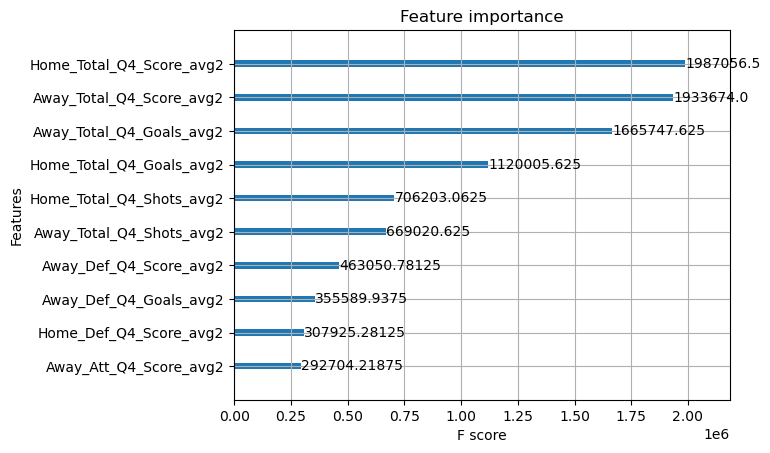

In [18]:
test_xgb_evals.plot_feature_importance(max_num_features=10, importance_type="total_gain")

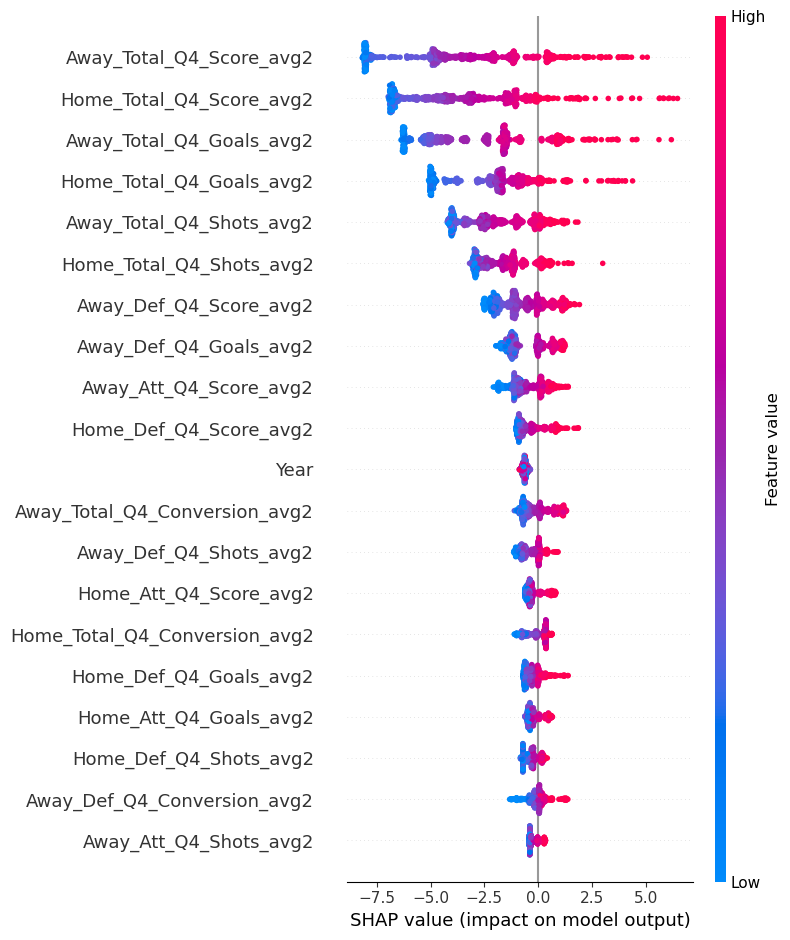

In [43]:
test_xgb_evals.plot_shap_summary_plot(20)

In [40]:
feature_list = [
    'Year'
]

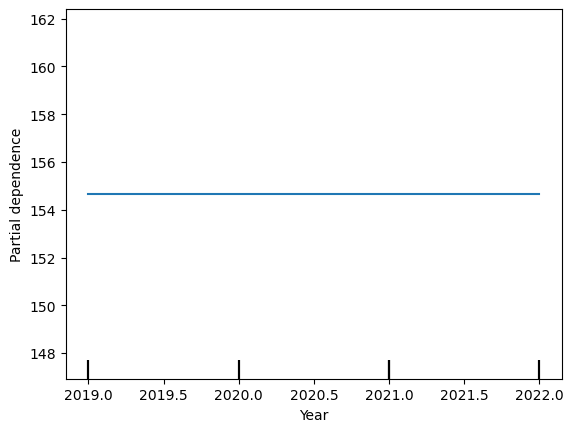

In [41]:
test_xgb_evals.plot_pdp(feature_list)

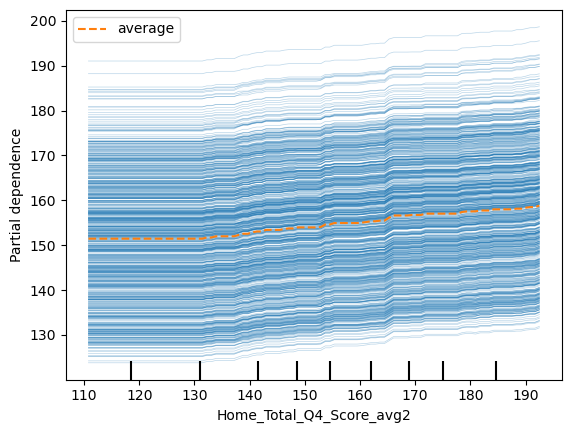

In [22]:
test_xgb_evals.plot_ice(feature_list)

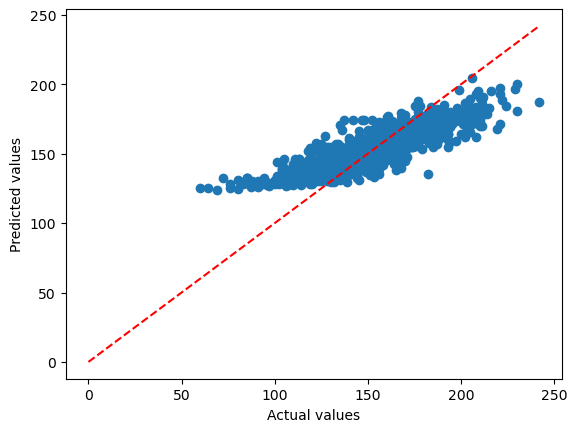

In [23]:
test_xgb_evals.plot_ave()

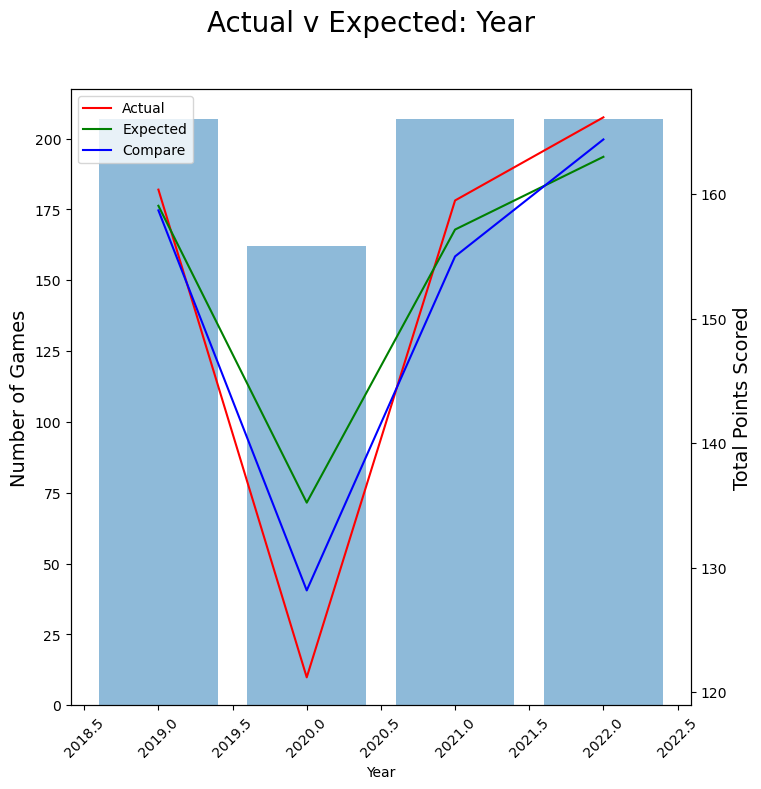

In [44]:
test_xgb_evals.plot_feature_ave('Year')

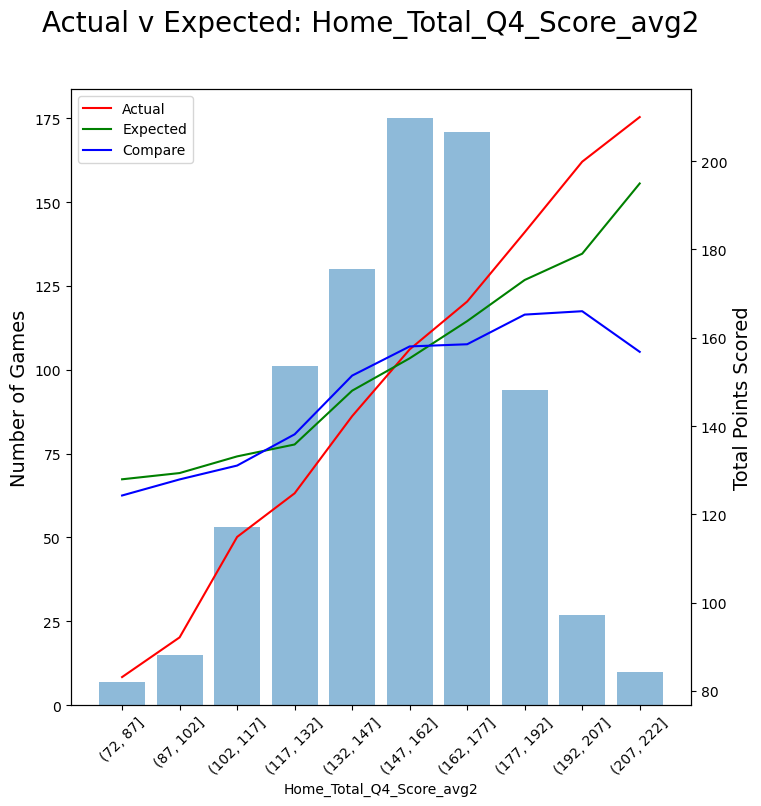

In [25]:
test_xgb_evals.plot_feature_ave('Home_Total_Q4_Score_avg2')

Model Metrics

In [26]:
test_xgb_evals.get_mae()

15.45477329999551

In [27]:
test_xgb_evals.get_mse()

374.97714762258704

In [28]:
test_xgb_evals.get_r2_score()

0.6169885243270609

Training Evaluation

In [29]:
train_evaluation_data = X_train_preproc.copy()
train_evaluation_data['xgb_preds'] = xgb_model.predict(X_train_preproc)
train_evaluation_data['old_preds'] = compare_train_data['xgb_preds']
train_evaluation_data[response] = training_data[response].reset_index(drop=True)
train_evaluation_data.head()

,Round,Year,Temperature,random5,Home_Total_Q4_Score_avg2,Home_Total_Q4_Goals_avg2,Home_Total_Q4_Behinds_avg2,Home_Total_Q4_Shots_avg2,Home_Total_Q4_Conversion_avg2,Home_Att_Q4_Score_avg2,Home_Att_Q4_Goals_avg2,Home_Att_Q4_Behinds_avg2,Home_Att_Q4_Shots_avg2,Home_Att_Q4_Conversion_avg2,Home_Def_Q4_Score_avg2,Home_Def_Q4_Goals_avg2,Home_Def_Q4_Behinds_avg2,Home_Def_Q4_Shots_avg2,Home_Def_Q4_Conversion_avg2,Away_Total_Q4_Score_avg2,Away_Total_Q4_Goals_avg2,Away_Total_Q4_Behinds_avg2,Away_Total_Q4_Shots_avg2,Away_Total_Q4_Conversion_avg2,Away_Att_Q4_Score_avg2,Away_Att_Q4_Goals_avg2,Away_Att_Q4_Behinds_avg2,Away_Att_Q4_Shots_avg2,Away_Att_Q4_Conversion_avg2,Away_Def_Q4_Score_avg2,Away_Def_Q4_Goals_avg2,Away_Def_Q4_Behinds_avg2,Away_Def_Q4_Shots_avg2,Away_Def_Q4_Conversion_avg2,Home_Team_Adelaide,Home_Team_Brisbane Lions,Home_Team_Carlton,Home_Team_Collingwood,Home_Team_Essendon,Home_Team_Fremantle,Home_Team_Geelong,Home_Team_Gold Coast,Home_Team_Greater Western Sydney,Home_Team_Hawthorn,Home_Team_Melbourne,Home_Team_North Melbourne,Home_Team_Port Adelaide,Home_Team_Richmond,Home_Team_St Kilda,Home_Team_Sydney,Home_Team_West Coast,Home_Team_Western Bulldogs,Away_Team_Adelaide,Away_Team_Brisbane Lions,Away_Team_Carlton,Away_Team_Collingwood,Away_Team_Essendon,Away_Team_Fremantle,Away_Team_Geelong,Away_Team_Gold Coast,Away_Team_Greater Western Sydney,Away_Team_Hawthorn,Away_Team_Melbourne,Away_Team_North Melbourne,Away_Team_Port Adelaide,Away_Team_Richmond,Away_Team_St Kilda,Away_Team_Sydney,Away_Team_West Coast,Away_Team_Western Bulldogs,Venue_Adelaide Oval,Venue_Bellerive Oval,Venue_Blacktown,Venue_Carrara,Venue_Cazalys Stadium,Venue_Docklands,Venue_Eureka Stadium,Venue_Football Park,Venue_Gabba,Venue_Jiangwan Stadium,Venue_Kardinia Park,Venue_M.C.G.,Venue_Manuka Oval,Venue_Marrara Oval,Venue_Perth Stadium,Venue_Princes Park,Venue_S.C.G.,Venue_Stadium Australia,Venue_Subiaco,Venue_Sydney Showground,Venue_Traeger Park,Venue_Wellington,Venue_York Park,City_Adelaide,City_Alice Springs,City_Ballarat,City_Brisbane,City_Cairns,City_Canberra,City_Darwin,City_Geelong,City_Gold Coast,City_Hobart,City_Launceston,City_Melbourne,City_Perth,City_Shanghai,City_Sydney,City_Wellington,Weather_Type_Bad,Weather_Type_Good,xgb_preds,old_preds,Total_Game_Score
0,1,2005.0,18.0,4,181.188342,26.305829,23.35337,49.659199,0.528876,91.5,13.281603,11.810383,25.091985,0.526871,89.688342,13.024226,11.542987,24.567213,0.528248,181.774299,26.394976,23.404441,49.799418,0.52913,90.031853,13.076629,11.572079,24.648708,0.528787,91.742446,13.318347,11.832363,25.15071,0.52722,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,175.782547,182.30550,209.0
1,1,2005.0,18.0,3,181.188342,26.305829,23.35337,49.659199,0.528876,91.5,13.281603,11.810383,25.091985,0.526871,89.688342,13.024226,11.542987,24.567213,0.528248,181.774299,26.394976,23.404441,49.799418,0.52913,90.031853,13.076629,11.572079,24.648708,0.528787,91.742446,13.318347,11.832363,25.15071,0.52722,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,175.695007,185.42467,190.0
2,1,2005.0,18.0,2,181.188342,26.305829,23.35337,49.659199,0.528876,91.5,13.281603,11.810383,25.091985,0.526871,89.688342,13.024226,11.542987,24.567213,0.528248,181.774299,26.394976,23.404441,49.799418,0.52913,90.031853,13.076629,11.572079,24.648708,0.528787,91.742446,13.318347,11.832363,25.15071,0.52722,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,175.519974,182.30550,160.0
3,1,2005.0,18.0,3,181.188342,26.305829,23.35337,49.659199,0.528876,91.5,13.281603,11.810383,25.091985,0.526871,89.688342,13.024226,11.542987,24.567213,0.528248,181.774299,26.394976,23.404441,49.799418,0.52913,90.031853,13.076629,11.572079,24.648708,0.528787,91.742446

In [30]:
train_xgb_evals = XGBRegressorEvaluator(model = xgb_model,
                                       data = train_evaluation_data,
                                       actual_name = response,
                                       expected_name = "xgb_preds",
                                       compare_name='old_preds'
                                       )

In [31]:
train_xgb_evals.get_mae()

17.10583258765579

In [32]:
train_xgb_evals.get_mse()

468.57442818564834

In [33]:
train_xgb_evals.get_r2_score()

0.5656041979210001

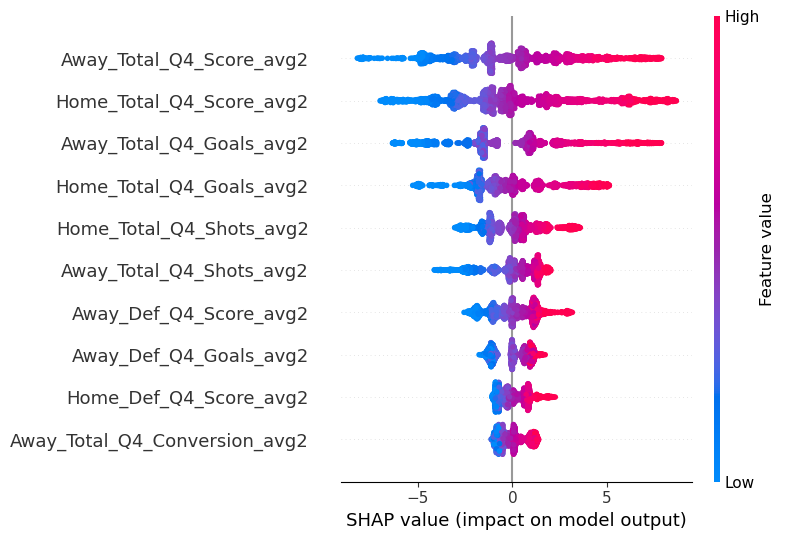

In [34]:
train_xgb_evals.plot_shap_summary_plot()

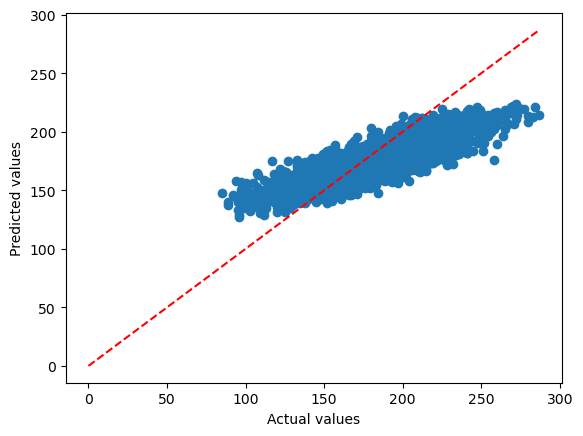

In [35]:
train_xgb_evals.plot_ave()

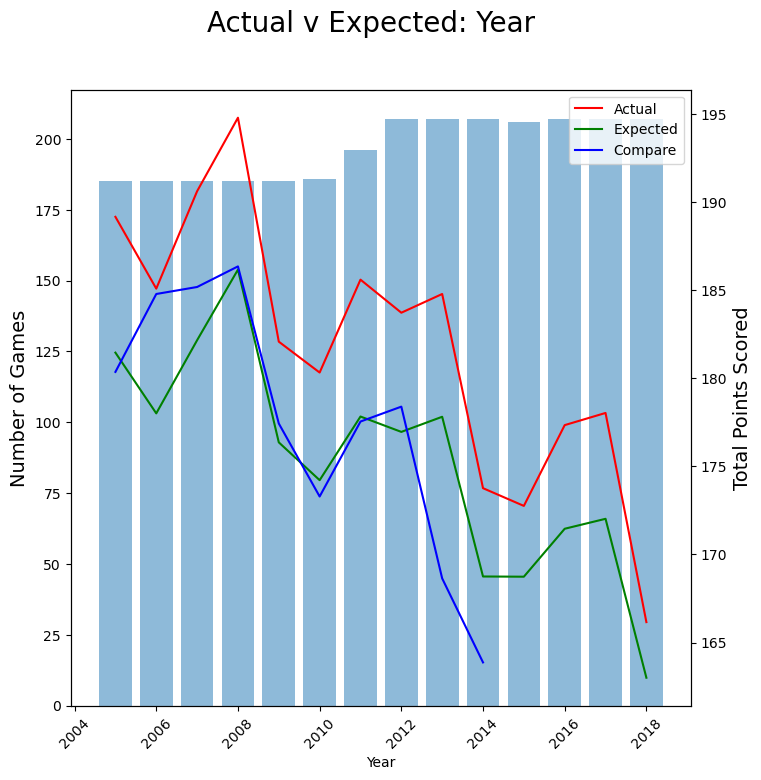

In [45]:
train_xgb_evals.plot_feature_ave('Year')

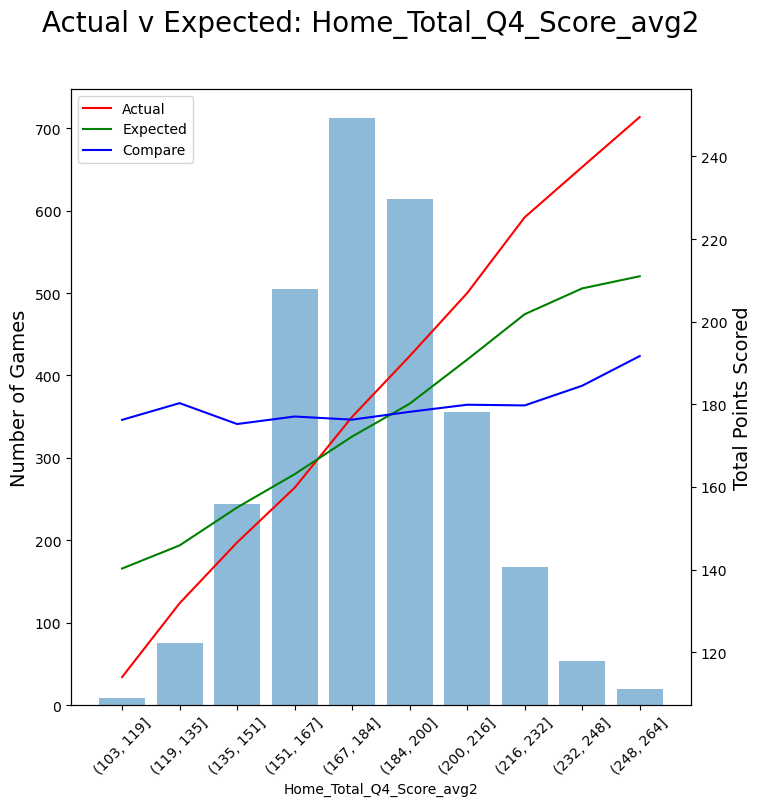

In [46]:
train_xgb_evals.plot_feature_ave('Home_Total_Q4_Score_avg2')

Double Lift

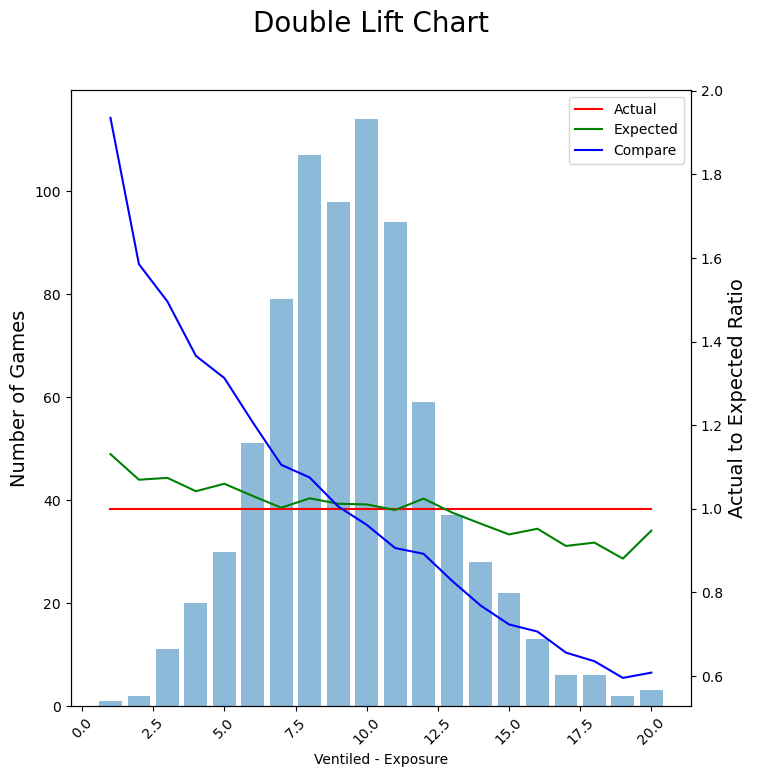

In [38]:
test_xgb_evals.plot_double_lift_chart()

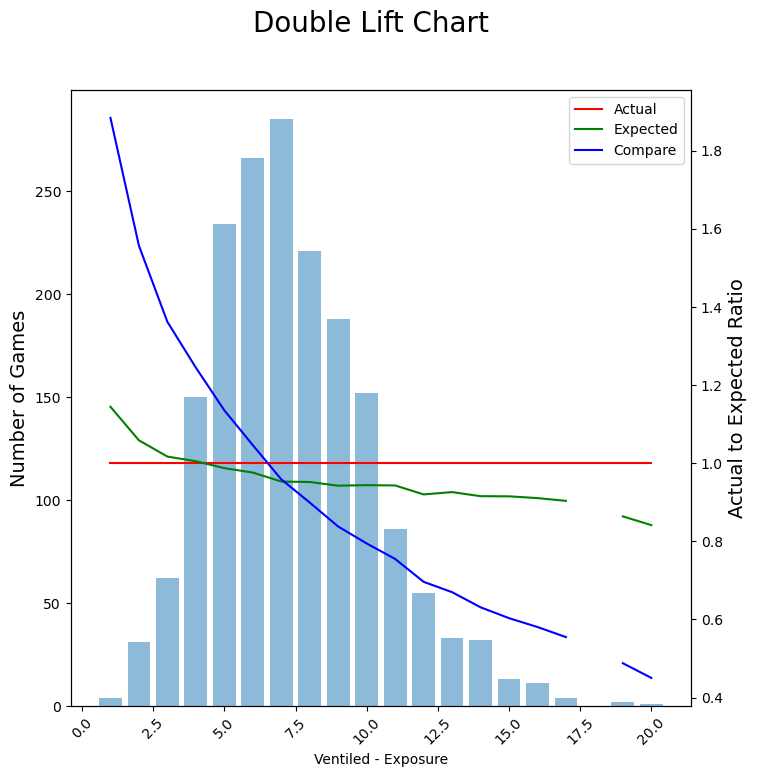

In [39]:
train_xgb_evals.plot_double_lift_chart()